In [1]:
import os
import pandas as pd
import numpy as np

from controllers.inference_controllers.sandbox import Sandbox
from controllers.inference_controllers.generator import Generator
from controllers.inference_controllers.optimiser import Optimiser

from toolboxes.plotting_toolbox.domain import Domain
from toolboxes.inference_toolbox.parameter import Parameter
from toolboxes.inference_toolbox.model import Model
from toolboxes.inference_toolbox.likelihood import Likelihood

current_directory = os.getcwd()
if current_directory != '/project/':
    os.chdir('/project/')

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
# data_params = {
#     'data_type': 'simulated_data',
#     'model': {
#         'model_select': 'log_gpm_norm',
#         'model_params':{
#             'H': 10
#         },
#         'inference_params':{
#             'I_y': 0.1,
#             'I_z': 0.1,
#             'Q': 3e13,
#             'sigma': 1
#         }
#     },
#     'domain':{
#         'domain_select': 'cone_from_source_z_limited',
#         'domain_params': {
#             'r': 100,
#             'theta': np.pi/8,
#             'source': [0,0,10]
#         },
#         'resolution': 20
#     },
#     'noise_dist': 'gaussian',
#     'noise_level': 1,
#     'output_header': 'Concentration',
# }

data_params = {
    'data_type': 'normalised_data',
    'data_select': 'GBR_data',
    'normaliser_select': 'GBR_normaliser',
    'normaliser_params':{
        'experiments_list': [
            'Exp1',
            'Exp2',
            'Exp3',
            'Exp4',
            'Exp5',
            'Exp6',
            'Exp7',
            'Exp8',
            'Exp9',
            'Exp10',
            'Exp11',
            'Exp12',
        ],
        'meta_data_select': 'GBR_data_summary',
        'input_header': 'Concentration'
    },
    'log':True,
    'output_header': 'Concentration',
    'gridding': [100,100,25]
}



default_params = {
    'infered_params':pd.Series({
        'model_params':pd.Series({
            'I_y': Parameter('I_y', prior_select = 'log_norm', default_value=0.1).add_prior_param('mu', 0.1).add_prior_param('sigma',0.1),
            'I_z': Parameter('I_z', prior_select = 'log_norm', default_value=0.1).add_prior_param('mu', 0.1).add_prior_param('sigma',0.1),
            'Q': Parameter('Q', prior_select = 'log_norm', default_value=3e13).add_prior_param('mu', 3e13).add_prior_param('sigma',1e13),
        }),
        'likelihood_params':pd.Series({
            'sigma': Parameter('sigma', prior_select = 'log_norm', default_value=1).add_prior_param('mu', 1).add_prior_param('sigma',1)
        })
    }),
    'model':Model('log_gpm_norm').add_model_param('H',10),
    'likelihood': Likelihood('gaussian'),
    'sampler': {
        'n_samples': 1000,
        'n_chains': 3,
        'thinning_rate': 1
    }
}

results_name = 'test_2'

In [3]:
sandbox = Sandbox(results_name=results_name, 
                  data_params=data_params,
                  default_params=default_params)

visualiser = sandbox.run()
visualiser.get_summary()
visualiser.get_traceplot()
visualiser.get_autocorrelations()

domain = Domain('cone_from_source_z_limited', resolution=80)
domain.add_domain_param('r', 100)
domain.add_domain_param('theta', np.pi/8)
domain.add_domain_param('source', [0,0,10])

visualiser.visualise_results(domain = domain, name = 'small_scale_3D_plots', title='Log Concentration of Droplets', log_results=False)
visualiser.animate(name = 'small_scale_3D_plots')

Loading Chain Samples...
Loading Samples...
Traceplot 1 already exists
Traceplot 2 already exists
Traceplot 3 already exists
Autocorrelations plot 1 already exists
Autocorrelations plot 2 already exists
Autocorrelations plot 3 already exists
Plots already exist!
Animation already exist!


In [4]:
generator = Generator(results_name=results_name, 
                  data_params=data_params,
                  default_params=default_params)

In [5]:
analysis_iterations = {
    'parameters_1':
    [
        'sigma_mu'
    ],
    'parameters_2':
    [
        'sigma_sigma'

    ],
    'values_1':
    [
        np.array([0.5, 1])     
    ],

    'values_2':
    [
        np.array([0.5, 1]) 
    ]
}

for i in range(len(analysis_iterations['parameters_1'])):
    parameter_1 = analysis_iterations['parameters_1'][i]
    parameter_2 = analysis_iterations['parameters_2'][i]

    print('Working on varying ' + parameter_1 + '...')
    values_1 = analysis_iterations['values_1'][i]
    values_2 = analysis_iterations['values_2'][i]
    inputs = generator.vary_two_parameters(parameter_1, parameter_2, values_1, values_2, scale_1='linear', scale_2='linear', plot=True)

Working on varying sigma_mu...


## Optimiser ##

Optimise the default construction using Bayesian Optimisation

[I 2023-10-04 05:27:24,934] Using an existing study with name 'BIC_1' instead of creating a new one.
/project/controllers/inference_controllers/optimiser.py:477: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)
/project/controllers/inference_controllers/optimiser.py:479: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


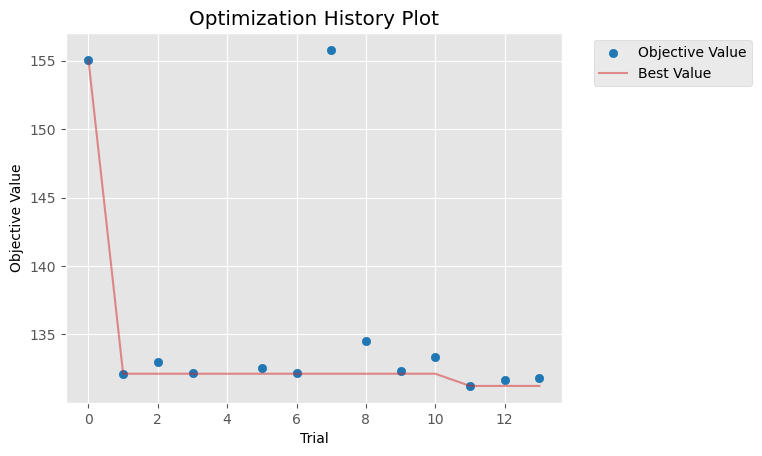

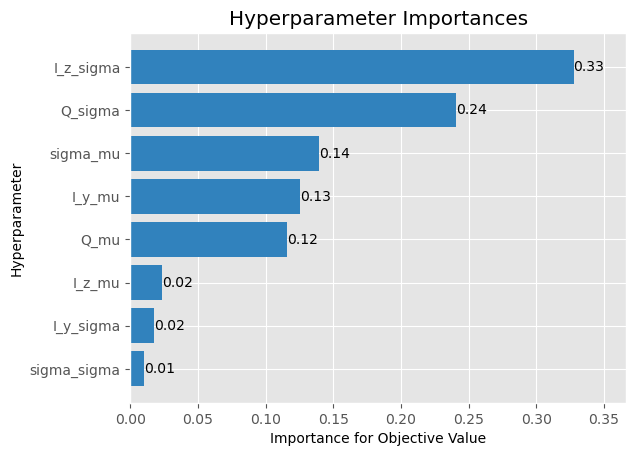

In [6]:
optimising_parameters = {
                    'I_y_mu': [1e-2, 10],
                    'I_y_sigma': [1e-2, 10],
                    'I_z_mu': [1e-2, 10],
                    'I_z_sigma': [1e-2, 10],
                    'Q_mu': [1e9, 1e18],
                    'Q_sigma': [1e9, 1e18],
                    'sigma_mu':[0.2, 2],
                    'sigma_sigma':[0.2, 2]
                }

optimiser = Optimiser(results_name=results_name, 
                  data_params=data_params,
                  default_params=default_params)

study = optimiser.run(n_trials=14, optimiser_name='BIC_1', optimising_parameters=optimising_parameters, index_name='bic')
optimiser.get_plots(study)

# Generates the plots and animation of the modeled system using the sampled parameters
domain = Domain('cone_from_source_z_limited', resolution=80)
domain.add_domain_param('r', 1000)
domain.add_domain_param('theta', np.pi/8)
domain.add_domain_param('source', [0,0,10])

optimiser.run_best_params(study, domain, name = 'small_scale_3D_plots')

